# Overview

This is a python script that addresses the following questions:

- What are the most popular departing and destination stations?
- What are the common origination and arrival area clusters (not just based on Zip Code)? 
- Which stations have high operational risks of running out or not supplying enough bikes?

Based on a quick conversation with an actual CitiBike operator who does bike balancing, here are a few operation setup:
- 3 shifts per day (i.e. morning, afternoon, and evening) 
- there are common pattern: tourist destination and commuter centers usually have bike accumulation
- dispatch center will specify an operator how many bike he needs to take and pickup / drop off location
- bikes are re-balanced to nearby stations

# Outputs
- Statistical and Graphical Analysis
- Monte Carlo Simulation for Operational Risk Assessment

# Reference

https://pythonprogramming.net/monte-carlo-simulator-python/

---

## Data Ingestion and Feature Engineering

In [112]:
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
import warnings
import matplotlib.style as style
from urllib.request import urlretrieve
import os
from shapely.geometry import Point
warnings.filterwarnings('ignore')
style.use('fivethirtyeight')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [173]:
# Download NYC Subway Stations Locations

url = "https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile"

try:
    urlretrieve(url, "subway.zip")
    if os.path.isfile("geo_export_055be448-1761-4ed6-b825-c799a575b2cc.shp"):
        print("Files exist. Pass.")
    else:
        !unzip subway.zip
except:
    pass

subway = gpd.GeoDataFrame.from_file("geo_export_055be448-1761-4ed6-b825-c799a575b2cc.shp")
subway.crs

Files exist. Pass.


{'init': 'epsg:4326'}

In [152]:
subway.head(5)

,notes,url,name,objectid,line,geometry
0,"4 nights, 6-all times, 6 Express-weekdays AM s...",http://web.mta.info/nyct/service/,Astor Pl,1.0,4-6-6 Express,POINT (-73.99106999861966 40.73005400028978)
1,"4 nights, 6-all times, 6 Express-weekdays AM s...",http://web.mta.info/nyct/service/,Canal St,2.0,4-6-6 Express,POINT (-74.00019299927328 40.71880300107709)
2,"1-all times, 2-nights",http://web.mta.info/nyct/service/,50th St,3.0,1-2,POINT (-73.98384899986625 40.76172799961419)
3,"4-nights, 3-all other times, 2-all times",http://web.mta.info/nyct/service/,Bergen St,4.0,2-3-4,POINT (-73.97499915116808 40.68086213682956)
4,"4-nights, 3-all other times",http://web.mta.info/nyct/service/,Pennsylvania Ave,5.0,3-4,POINT (-73.89488591154061 40.66471445143568)


In [174]:
# Download NYC Basemap

url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

try:
    urlretrieve(url, "file.zip")
    if os.path.isfile("geo_export_04b91470-87bd-4f6c-bae8-406f62b9cb9a.shp"):
        print("Files exist. Pass.")
    else:
        !unzip file.zip
except:
    pass

nyc_map = gpd.GeoDataFrame.from_file("geo_export_04b91470-87bd-4f6c-bae8-406f62b9cb9a.shp")
nyc_map.crs

Files exist. Pass.


{'init': 'epsg:4326'}

In [182]:
bike = pd.read_csv("https://s3.amazonaws.com/tripdata/201709-citibike-tripdata.csv.zip")
bike.shape

(1878098, 15)

In [183]:
bike.sample(10)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
1164278,818,2017-09-20 08:52:29,2017-09-20 09:06:07,376,John St & William St,40.708621,-74.007222,307,Canal St & Rutgers St,40.714275,-73.989900,16659,Subscriber,1981.0,1
610147,180,2017-09-11 19:56:54,2017-09-11 19:59:54,497,E 17 St & Broadway,40.737050,-73.990093,325,E 19 St & 3 Ave,40.736245,-73.984738,26789,Subscriber,1976.0,1
1187711,286,2017-09-20 15:50:06,2017-09-20 15:54:52,460,S 4 St & Wythe Ave,40.712859,-73.965903,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,20243,Subscriber,1983.0,2
207768,1062,2017-09-05 14:15:07,2017-09-05 14:32:50,3142,1 Ave & E 62 St,40.761227,-73.960940,3159,W 67 St & Broadway,40.774925,-73.982666,29703,Customer,NaN,0
1567434,1123,2017-09-26 09:48:31,2017-09-26 10:07:15,3447,E 71 St & 1 Ave,40.767034,-73.956227,173,Broadway & W 49 St,40.760683,-73.984527,29895,Subscriber,1972.0,1
779783,583,2017-09-14 09:16:06,2017-09-14 09:25:50,3282,5 Ave & E 88 St,40.783070,-73.959390,3359,E 68 St & Madison Ave,40.769157,-73.967035,24846,Subscriber,1954.0,2
29259,359,2017-09-01 14:25:39,2017-09-01 14:31:39,428,E 3 St & 1 Ave,40.724677,-73.987834,237,E 11 St & 2 Ave,40.730473,-73.986724,27877,Subscriber,1986.0,1
1728172,524,2017-09-28 15:58:15,2017-09-28 16:07:00,3435,Grand St & Elizabeth St,40.718822,-73.995960,257,Lispenard St & Broadway,40.719392,-74.002472,27885,Subscriber,1960.0,1
1175649,579,2017-09-20 12:11:38,2017-09-20 12:21:17,3164,Columbus Ave & W 72 St,40.777057,-73.978985,3169,Riverside Dr & W 82 St,40.787209,-73.981281,19045,Subscriber,1962.0,2
415642,640,2017-09-08 19:10:32,2017-09-08 19:21:13,3420,Douglass St & 3 Ave,40.680213,-73.984327,3298,Warren St & Court St,40.686371,-73.993833,27864,Subscriber,1969.0,1


In [184]:
bike['starttime'] = pd.to_datetime(bike['starttime'], infer_datetime_format= True)
bike['stoptime'] = pd.to_datetime(bike['stoptime'], infer_datetime_format= True)

In [205]:
print("max time: {} |  min time: {}".format(bike['starttime'].max(), bike['starttime'].min()))

max time: 2017-09-30 23:59:52 |  min time: 2017-09-01 00:00:17


In [185]:
bike['day'] = bike['starttime'].dt.day
bike['start_hour'] = bike['starttime'].dt.hour
bike['end_hour'] = bike['stoptime'].dt.hour
bike['DOW'] = bike['starttime'].dt.dayofweek

In [186]:
bike.sample(10)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,day,start_hour,end_hour,DOW
843639,2634,2017-09-15 08:12:12,2017-09-15 08:56:07,3226,W 82 St & Central Park West,40.782750,-73.971370,3226,W 82 St & Central Park West,40.782750,-73.971370,25147,Subscriber,1957.0,1,15,8,8,4
1218526,443,2017-09-20 22:00:20,2017-09-20 22:07:44,410,Suffolk St & Stanton St,40.720664,-73.985180,251,Mott St & Prince St,40.723180,-73.994800,28454,Subscriber,1982.0,1,20,22,22,2
415605,2149,2017-09-08 19:10:09,2017-09-08 19:45:58,3390,E 109 St & 3 Ave,40.793297,-73.943208,3258,W 27 St & 10 Ave,40.750182,-74.002184,17881,Subscriber,1974.0,1,8,19,19,4
315260,207,2017-09-07 13:31:59,2017-09-07 13:35:26,3390,E 109 St & 3 Ave,40.793297,-73.943208,3400,E 110 St & Madison Ave,40.796153,-73.947821,28337,Subscriber,1985.0,1,7,13,13,3
724217,1046,2017-09-13 13:35:34,2017-09-13 13:53:01,3163,Central Park West & W 68 St,40.773407,-73.977825,3168,Central Park West & W 85 St,40.784727,-73.969617,29817,Customer,NaN,0,13,13,13,2
1111126,789,2017-09-19 09:41:58,2017-09-19 09:55:07,525,W 34 St & 11 Ave,40.755942,-74.002116,127,Barrow St & Hudson St,40.731724,-74.006744,21062,Subscriber,1973.0,1,19,9,9,1
1742719,301,2017-09-28 18:15:27,2017-09-28 18:20:29,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,31220,Subscriber,1976.0,1,28,18,18,3
1833331,1024,2017-09-30 09:15:07,2017-09-30 09:32:12,3074,Montrose Ave & Bushwick Ave,40.707678,-73.940162,3087,Metropolitan Ave & Meeker Ave,40.714133,-73.952344,28206,Customer,NaN,0,30,9,9,5
1842502,1146,2017-09-30 12:00:12,2017-09-30 12:19:19,380,W 4 St & 7 Ave S,40.734011,-74.002939,152,Warren St & Church St,40.714740,-74.009106,31976,Customer,NaN,0,30,12,12,5
484547,555,2017-09-09 22:44:30,2017-09-09 22:53:46,302,Avenue D & E 3 St,40.720828,-73.977932,428,E 3 St & 1 Ave,40.724677,-73.987834,28050,Subscriber,1989.0,1,9,22,22,5


---

## Quantitative Analysis
- Find all unique station and its location details
- Count the number of trips and group by starting and ending station accordingly
- Create a table of bike station, hour, total # of departure, total # of arrival, # of bikes at the dock, and lat/long; assuming there are 20 bikes at the beginning of the day at 12 a.m.

In [187]:
uni_dep_stations = bike[['start station id', 'start station name', 'start station latitude', 'start station longitude']].drop_duplicates()
uni_arv_stations = bike[['end station id', 'end station name', 'end station latitude', 'end station longitude']].drop_duplicates()

In [188]:
print ("number of unique departure stations: {}".format(uni_dep_stations.shape[0]))

number of unique departure stations: 680


In [189]:
print ("number of unique arrival stations: {}".format(uni_arv_stations.shape[0]))

number of unique arrival stations: 696


In [190]:
# Create a dataset with all unique station id, name, and lat/lon
uni_dep_stations.columns = ["id", "name", "lat", "lon"]
uni_arv_stations.columns = ["id", "name", "lat", "lon"]
uni_station = pd.concat([uni_dep_stations, uni_arv_stations], axis = 0).drop_duplicates()
uni_station.head()

,id,name,lat,lon
0,3331,Riverside Dr & W 104 St,40.801343,-73.971146
1,3101,N 12 St & Bedford Ave,40.720798,-73.954847
2,3140,1 Ave & E 78 St,40.771404,-73.953517
3,236,St Marks Pl & 2 Ave,40.728419,-73.987140
4,3427,Lafayette St & Jersey St,40.724305,-73.996010


In [191]:
print ("number of unique stations: {}".format(uni_station.shape[0]))

number of unique stations: 696


### Top 5 Stations with The Most Departure Trips in Sept. 2017

In [192]:
start_count = bike.groupby("start station id").size().reset_index(name = "departure_cnt").\
                sort_values(by = "departure_cnt", ascending = False)
start_count = start_count.merge(uni_dep_stations, how = "left", left_on = "start station id", right_on = "id")
start_count.head(5)

,start station id,departure_cnt,id,name,lat,lon
0,519,17359,519,Pershing Square North,40.751873,-73.977706
1,426,13132,426,West St & Chambers St,40.717548,-74.013221
2,497,12391,497,E 17 St & Broadway,40.737050,-73.990093
3,435,11517,435,W 21 St & 6 Ave,40.741740,-73.994156
4,402,11483,402,Broadway & E 22 St,40.740343,-73.989551


### Top 5 Stations with The Most Arrival Trip in Sept. 2017

In [193]:
end_count = bike.groupby("end station id").size().reset_index(name = "arrival_cnt").\
                sort_values(by = "arrival_cnt", ascending = False)
end_count = end_count.merge(uni_arv_stations, how = "left", left_on = "end station id", right_on = "id")
end_count.head(5)

,end station id,arrival_cnt,id,name,lat,lon
0,519,17056,519,Pershing Square North,40.751873,-73.977706
1,426,14917,426,West St & Chambers St,40.717548,-74.013221
2,497,12704,497,E 17 St & Broadway,40.737050,-73.990093
3,402,11830,402,Broadway & E 22 St,40.740343,-73.989551
4,435,11668,435,W 21 St & 6 Ave,40.741740,-73.994156


### The Stations with the Most and Least Bike Balance on Sept 1, 2017

- create dataset of # of arrival by hour
- create dataset of # of departure by hour
- create dataset with net flow by hour
- create dataset with end-of-hour bike balances; assume 20 bikes at 12am

Technique
- long-to-wide table transpose - https://pandas.pydata.org/pandas-docs/stable/reshaping.html

In [211]:
bike.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
day                                 int64
start_hour                          int64
end_hour                            int64
DOW                                 int64
dtype: object

In [230]:
# Create hourly departure count by day across the month

monthDep = pd.pivot_table(bike[['start station id', 'day','start_hour']],
                             index = "start station id", columns = ['day', "start_hour"], 
                             aggfunc = np.size, fill_value= 0).reset_index()

monthDep.columns = ["dep_" + str(day) + "_" + str(hour) for day, hour in monthDep.columns]

In [232]:
# Create hourly arrival count by day across the month

monthArv = pd.pivot_table(bike[['end station id', 'day','end_hour']],
                             index = "end station id", columns = ['day', "end_hour"], 
                             aggfunc = np.size, fill_value= 0).reset_index()

monthArv.columns = ["arv_" + str(day) + "_" + str(hour) for day, hour in monthArv.columns]

In [237]:
# Create a hourly net flow count by day across the month 

monthNet = uni_station.merge(monthDep, how = "left", left_on = "id", right_on = "dep_start station id_").\
                      merge(monthArv, how = "left", left_on = "id", right_on = "arv_end station id_").fillna(0)

for day in range(1, 31):
        
    for hour in range(0, 24):
        
        try:
            net_col = "net_" + str(day) + "_" + str(hour)
            dep_col = "dep_" + str(day) + "_" + str(hour)
            arv_col = "arv_" + str(day) + "_" + str(hour)
            monthNet[net_col] = monthNet[arv_col] - monthNet[dep_col]
        except (KeyError):
            print("Missing day: {} | Missing hour: {}".format(day, hour))
            pass

monthNet.sample(10)

,id,name,lat,lon,dep_start station id_,dep_1_0,dep_1_1,dep_1_2,dep_1_3,dep_1_4,dep_1_5,dep_1_6,dep_1_7,dep_1_8,dep_1_9,dep_1_10,dep_1_11,dep_1_12,dep_1_13,dep_1_14,dep_1_15,dep_1_16,dep_1_17,dep_1_18,dep_1_19,dep_1_20,dep_1_21,dep_1_22,dep_1_23,dep_2_0,dep_2_1,dep_2_2,dep_2_3,dep_2_4,dep_2_5,dep_2_6,dep_2_7,dep_2_8,dep_2_9,dep_2_10,dep_2_11,dep_2_12,dep_2_13,dep_2_14,dep_2_15,dep_2_16,dep_2_17,dep_2_18,dep_2_19,dep_2_20,dep_2_21,dep_2_22,dep_2_23,dep_3_0,dep_3_1,dep_3_2,dep_3_3,dep_3_4,dep_3_5,dep_3_6,dep_3_7,dep_3_8,dep_3_9,dep_3_10,dep_3_11,dep_3_12,dep_3_13,dep_3_14,dep_3_15,dep_3_16,dep_3_17,dep_3_18,dep_3_19,dep_3_20,dep_3_21,dep_3_22,dep_3_23,dep_4_0,dep_4_1,dep_4_2,dep_4_3,dep_4_4,dep_4_5,dep_4_6,dep_4_7,dep_4_8,dep_4_9,dep_4_10,dep_4_11,dep_4_12,dep_4_13,dep_4_14,dep_4_15,dep_4_16,dep_4_17,dep_4_18,dep_4_19,dep_4_20,dep_4_21,dep_4_22,dep_4_23,dep_5_0,dep_5_1,dep_5_2,dep_5_3,dep_5_4,dep_5_5,dep_5_6,dep_5_7,dep_5_8,dep_5_9,dep_5_10,dep_5_11,dep_5_12,dep_5_13,dep_5_14,dep_5_15,dep_5_16,dep_5_17,dep_5_18,dep_5_19,dep_5_20,dep_5_21,dep_5_22,dep_5_23,dep_6_0,dep_6_1,dep_6_2,dep_6_3,dep_6_4,dep_6_5,dep_6_6,dep_6_7,dep_6_8,dep_6_9,dep_6_10,dep_6_11,dep_6_12,dep_6_13,dep_6_14,dep_6_15,dep_6_16,dep_6_17,dep_6_18,dep_6_19,dep_6_20,dep_6_21,dep_6_22,dep_6_23,dep_7_0,dep_7_1,dep_7_2,dep_7_3,dep_7_4,dep_7_5,dep_7_6,dep_7_7,dep_7_8,dep_7_9,dep_7_10,dep_7_11,dep_7_12,dep_7_13,dep_7_14,dep_7_15,dep_7_16,dep_7_17,dep_7_18,dep_7_19,dep_7_20,dep_7_21,dep_7_22,dep_7_23,dep_8_0,dep_8_1,dep_8_2,dep_8_3,dep_8_4,dep_8_5,dep_8_6,dep_8_7,dep_8_8,dep_8_9,dep_8_10,dep_8_11,dep_8_12,dep_8_13,dep_8_14,dep_8_15,dep_8_16,dep_8_17,dep_8_18,dep_8_19,dep_8_20,dep_8_21,dep_8_22,dep_8_23,dep_9_0,dep_9_1,dep_9_2,dep_9_3,dep_9_4,dep_9_5,dep_9_6,dep_9_7,dep_9_8,dep_9_9,dep_9_10,dep_9_11,dep_9_12,dep_9_13,dep_9_14,dep_9_15,dep_9_16,dep_9_17,dep_9_18,dep_9_19,dep_9_20,dep_9_21,dep_9_22,dep_9_23,dep_10_0,dep_10_1,dep_10_2,dep_10_3,dep_10_4,dep_10_5,dep_10_6,dep_10_7,dep_10_8,dep_10_9,dep_10_10,dep_10_11,dep_10_12,dep_10_13,dep_10_14,dep_10_15,dep_10_16,dep_10_17,dep_10_18,dep_10_19,dep_10_20,dep_10_21,dep_10_22,dep_10_23,dep_11_0,dep_11_1,dep_11_2,dep_11_3,dep_11_4,...,net_20_14,net_20_15,net_20_16,net_20_17,net_20_18,net_20_19,net_20_20,net_20_21,net_20_22,net_20_23,net_21_0,net_21_1,net_21_2,net_21_3,net_21_4,net_21_5,net_21_6,net_21_7,net_21_8,net_21_9,net_21_10,net_21_11,net_21_12,net_21_13,net_21_14,net_21_15,net_21_16,net_21_17,net_21_18,net_21_19,net_21_20,net_21_21,net_21_22,net_21_23,net_22_0,net_22_1,net_22_2,net_22_3,net_22_4,net_22_5,net_22_6,net_22_7,net_22_8,net_22_9,net_22_10,net_22_11,net_22_12,net_22_13,net_22_14,net_22_15,net_22_16,net_22_17,net_22_18,net_22_19,net_22_20,net_22_21,net_22_22,net_22_23,net_23_0,net_23_1,net_23_2,net_23_3,net_23_4,net_23_5,net_23_6,net_23_7,net_23_8,net_23_9,net_23_10,net_23_11,net_23_12,net_23_13,net_23_14,net_23_15,net_23_16,net_23_17,net_23_18,net_23_19,net_23_20,net_23_21,net_23_22,net_23_23,net_24_0,net_24_1,net_24_2,net_24_3,net_24_4,net_24_5,net_24_6,net_24_7,net_24_8,net_24_9,net_24_10,net_24_11,net_24_12,net_24_13,net_24_14,net_24_15,net_24_16,net_24_17,net_24_18,net_24_19,net_24_20,net_24_21,net_24_22,net_24_23,net_25_0,net_25_1,net_25_2,net_25_3,net_25_4,net_25_5,net_25_6,net_25_7,net_25_8,net_25_9,net_25_10,net_25_11,net_25_12,net_25_13,net_25_14,net_25_15,net_25_16,net_25_17,net_25_18,net_25_19,net_25_20,net_25_21,net_25_22,net_25_23,net_26_0,net_26_1,net_26_2,net_26_3,net_26_4,net_26_5,net_26_6,net_26_7,net_26_8,net_26_9,net_26_10,net_26_11,net_26_12,net_26_13,net_26_14,net_26_15,net_26_16,net_26_17,net_26_18,net_26_19,net_26_20,net_26_21,net_26_22,net_26_23,net_27_0,net_27_1,net_27_2,net_27_3,net_27_4,net_27_5,net_27_6,net_27_7,net_27_8,net_27_9,net_27_10,net_27_11,net_27_12,net_27_13,net_27_14,net_27_15,net_27_16,net_27_17,net_27_18,net_27_19,net_27_20,net_27_21,net_27_22,net_27_23,net_28_0,net_28_1,net_28_2,net_28_3,net_28_4,net_28_5,net_28_6,net_28_7,net_28_8,net_28_9,net_28_10,net_28_11,net_28_1

In [332]:
# Calculate end-of-hour bike balance and percentage change 

def calHourlyBal(df, starting_bal):
    
    hourBal = df
    
    # Calculate hourly bike balance based on starting stock
    for day in range(1, 31):
        for hour in range(0, 24):
            try:
                
                if day == 1 and hour == 0:
                    bal_col = "bal_1_0"
                    hourBal["bal_1_0"] = starting_bal
                    
                elif day > 1 and hour == 0:
                    
                    bal_col = "bal_" + str(day) + "_" + str(hour)
                    last_bal_col = "bal_" + str(day-1) + "_23"
                    net_col = "net_" + str(day) + "_0"
                    
                    hourBal[bal_col] = hourBal[last_bal_col] + hourBal[net_col]
                
                else:
                    
                    bal_col = "bal_" + str(day) + "_" + str(hour)
                    last_bal_col = "bal_" + str(day) + "_" + str(hour-1)
                    net_col = "net_" + str(day) + "_" + str(hour)
                                        
                    hourBal[bal_col] = hourBal[last_bal_col] + hourBal[net_col]
            
            except (KeyError) as ex:
                # use previous balance for missing time slot
                print("Missing net flow at day {} hour {}".format(day, hour))
                
                #hourBal[bal_col] = hourBal[last_bal_col]
                pass

    # Calculate % change relative to starting stock
    for day in range(1, 31):
        for hour in range(0, 24):
            try:

                if day == 1 and hour == 0:
                    hourBal["chg_1_0"] = 1

                else:
                    chg_col = "chg_"+str(day)+ "_" + str(hour)
                    bal_col = "bal_"+str(day)+ "_" + str(hour)
                    hourBal[chg_col] = hourBal[bal_col] / hourBal["bal_1_0"]
            
            except (KeyError) as ex:
                # use previous balance for missing time slot
                print("Missing: {} col".format(ex))
                last_chg_col = "chg_" + str(i-1)
                hourBal[chg_col] = hourBal[last_chg_col]
                pass
    
    # Only keep balance and change columns
    bal_col = monthBal.columns[monthBal.columns.str.contains("bal_")]
    chg_col = monthBal.columns[monthBal.columns.str.contains("chg_")]

    final_bal = pd.concat([hourBal[["id", "name", "lat", "lon"]], hourBal[bal_col]], axis = 1) 
    final_chg = pd.concat([hourBal[["id", "name", "lat", "lon"]], hourBal[chg_col]], axis = 1)
    
    return final_bal, final_chg

In [335]:
# Calculate hourly bike balance and relative change based on a starting amount

final_bal, final_chg = calHourlyBal(monthNet, 50)

---

## Visual Analysis - One Day Analysis (Sept 1, 2017)

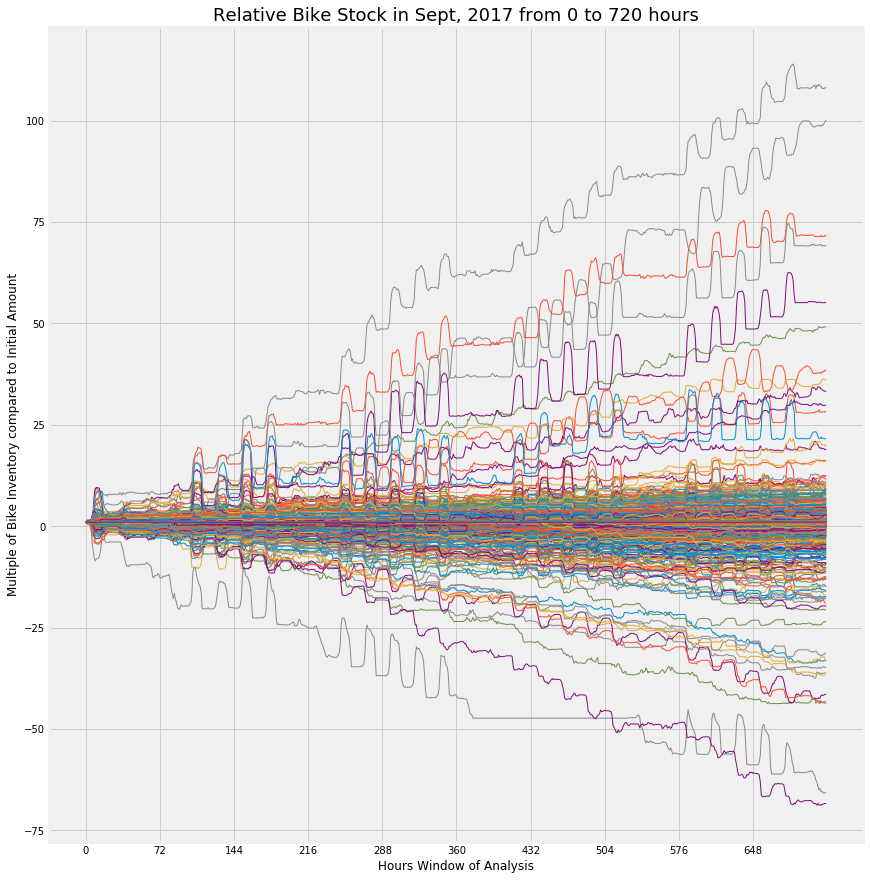

In [336]:
# Plot Time Series of net flow by station and hour

def plot_change(df, first_hour, last_hour):
    
    '''
    This function plots the % change of bike stock based on selected hour range
    '''
    listStation = []
    # convert to list
    
    for i in range(0, df.shape[0]):
        listStation.append(df.iloc[i, first_hour + 4: last_hour + 4].values.tolist())
    
    
    # Visualize
    fig = plt.figure(figsize = (13, 15));
    ax = fig.add_subplot(111);
    x_tick = range(first_hour, last_hour)
    for station in range(0, len(listStation)):
        
        plt.plot(x_tick, listStation[station], linewidth = 1)
    
    
    plt.xticks(np.arange(min(x_tick), max(x_tick)+1, int((min(x_tick)+max(x_tick)+1)/10)));
    plt.xlabel("Hours Window of Analysis", size = 12);
    plt.ylabel("Multiple of Bike Inventory compared to Initial Amount", size = 12);
    plt.title("Relative Bike Stock in Sept, 2017 from {} to {} hours".format(first_hour, last_hour), size = 18);
    

# Plot based on hour range
plot_change(final_chg, 0, 720)


### Caption

This is a time series chart of the multiple of bike inventory by hours from Sept 1 to 30, 2017 of all 696 stations. The visualization shows clear commutor pattern at certain stations. The ones with chainsaw patterns suggests morning and evening rush hour spikes follow by steady usage over the weekend. 

In addition, some stations accumulate bike much faster than others over a period of a month. This is a not true representation because assumptions regarding initial bike inventory at each stations were set to 50, it is used to calculate inventory for all subsequent hourly bike inventory based on departure and arrival trips. In reality, different stations have different avereage bike inventory depending on the locaiton. The current re-balancing is not taken into account because such information is not available. With re-balancing, the bike inventory will be re-set to a certain level about 3 times a day. This will drastically reduce the accumulation effect. 

This can be considered as **a baseline scenario without re-balancing**.

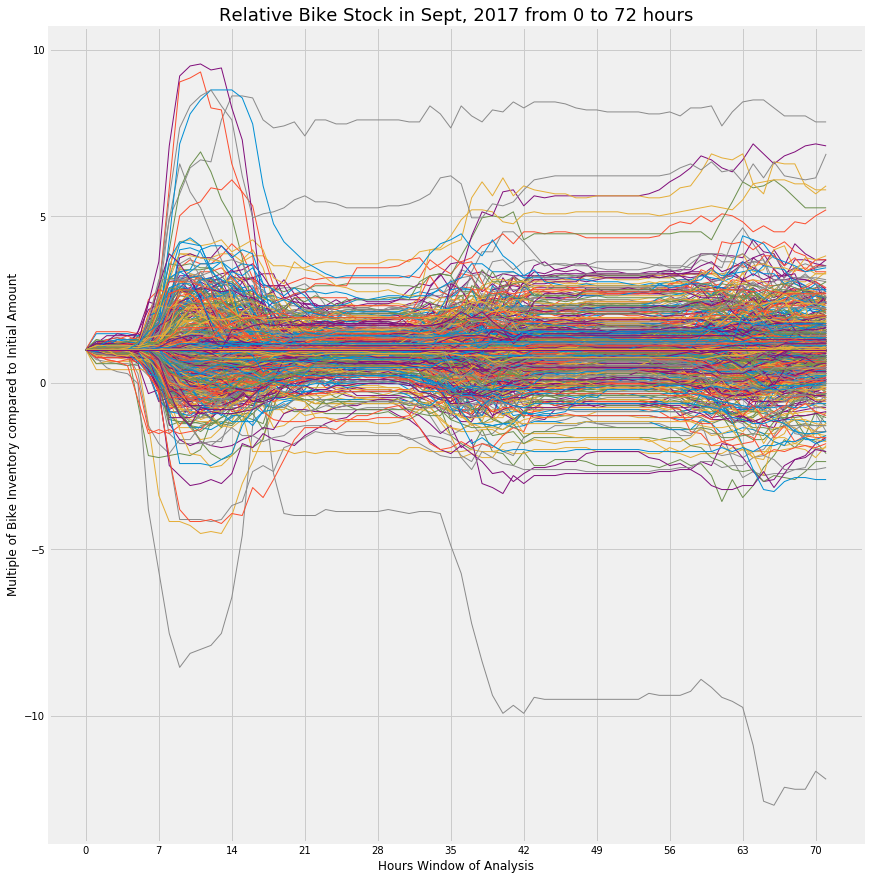

In [338]:
plot_change(final_chg, 0, 72)

# Caption 

This is a time series plot of bike balance at end of each hour assuming there are **50 bikes** at 12am on Sep 1, 2017. This graph include 696 stations that have any activities on Sept 1, 2017. Due to the space limit, the list of stations with the most and least bike balance at 23pm is shown below.

This visual analysis shows general departure and arrival traffic during rush hours from around 7-11am and 5-7pm. The bike balance at certain hours suggest that some stations are the popular destinations (e.g. grey line) and others are oringiation stations (e.g. green line). 

# Insights & Discussion
Some stations experience over-stock while some sees under-supply of bikes throughout the day. Assuming 20 initial bikes at 12am, some stations accumulates about **5-10 times** of the original bike stock throughout the day in the first 72 hours. In this case, riders may not be able to find a dock to park the bike unless they travel to a nearby station. This suggests the planning of # of free bike rack is important to avoid overflowing of bike. 

In contrast, some stations experience high demands of bikes for departure trips, **~5-8 times** the original bike stock. Having enough bikes at these high demand stations is critical to service delivery. This insight is reflective of actual situations. According to CitiBike website, they offer valet stations at peak hours to offer more bikes and docks to alleviate the gap of the supply-demand of bike and docking stations. These valet stations are near Penn Station, Port Authority, lower Manhattan.

The relative change in bike stock obviosly will change depanding on the initial assumption of bike stock. This visual analysis provides a directional sense of the dynamics of how bike stocks accumulate or deplete during the day. With this mechanism, one can develop a station-specific optimiazation model to determine the optimal amount of initial bike stock, which informs the amount of rebalancing, to minimize the "bike inventory" stress.

In [341]:
# Top 5 stations with the most bike at 11pm, Sept 1, 2017
final_bal.sort_values(by = "bal_30_23", ascending= False).head(5)[["id", "name", "bal_30_23"]]

,id,name,bal_30_23
106,426,West St & Chambers St,5411.0
136,432,E 7 St & Avenue A,5009.0
253,304,Broadway & Battery Pl,3572.0
334,520,W 52 St & 5 Ave,3455.0
263,3443,W 52 St & 6 Ave,2759.0


In [342]:
# Top 5 stations with the least bike at 11pm, Sept 1, 2017
final_bal.sort_values(by = "bal_30_23", ascending= True).head(5)[["id", "name", "bal_30_23"]]

,id,name,bal_30_23
197,3164,Columbus Ave & W 72 St,-3418.0
76,281,Grand Army Plaza & Central Park S,-3289.0
45,499,Broadway & W 60 St,-2185.0
295,3161,W 76 St & Columbus Ave,-2164.0
239,487,E 20 St & FDR Drive,-2065.0


---

## Clustering Analysis

- Create clustering features
- Perform K-Means Clustering
- Visualize on a Geo Spatial Map

In [ ]:
# Create clustering features



---

# GeoSpatial Analysis

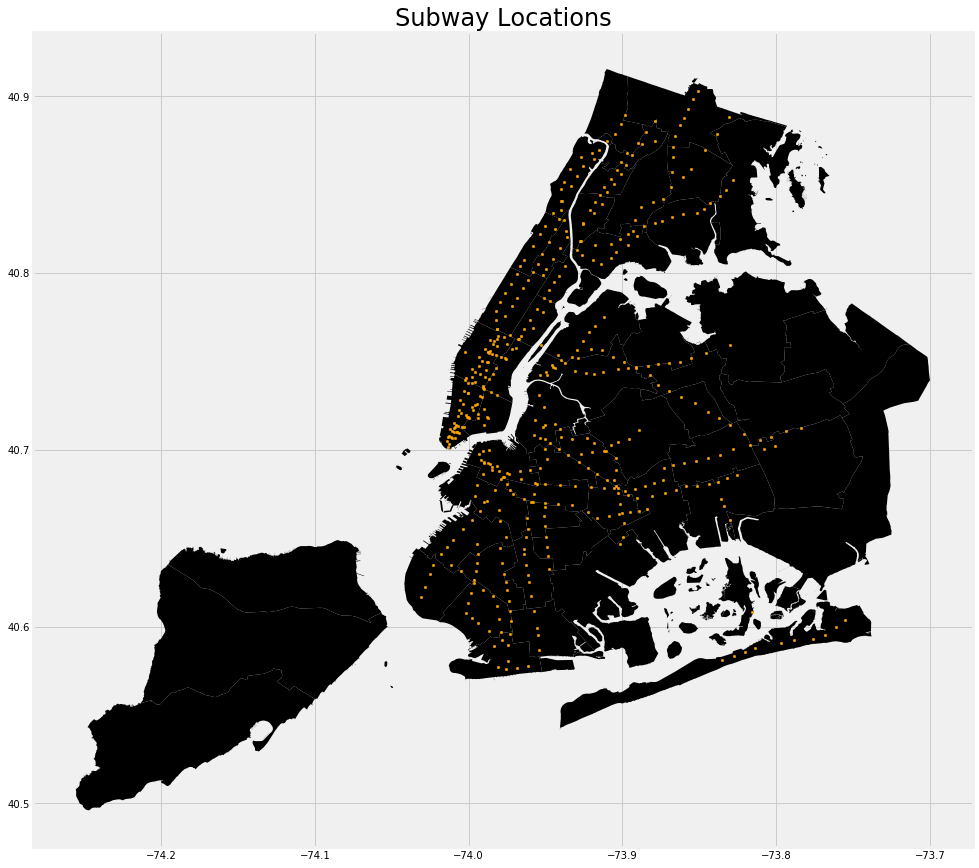

In [181]:
# Subway Locations

f, ax = plt.subplots(figsize = (15, 15));
nyc_map.plot(ax = ax, color = "black");
subway.plot(ax = ax, color = "orange", markersize = 6);
ax.set_title("Subway Locations", size = 24);

---

# Next Steps

Additional Questions: 
- Does bike stations encourage multi-modal travelling?
- How many trips ends near a subway station?


# Potential Hypothesis Testing

the average number of arrival trips is higher compared to the ones that are remote from any subway stations.


# Key Methods 
- Pairwise Distance (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html)
- Spatial Visualization